# Detection of miPSCs

## Upload of images

(480, 640, 3)

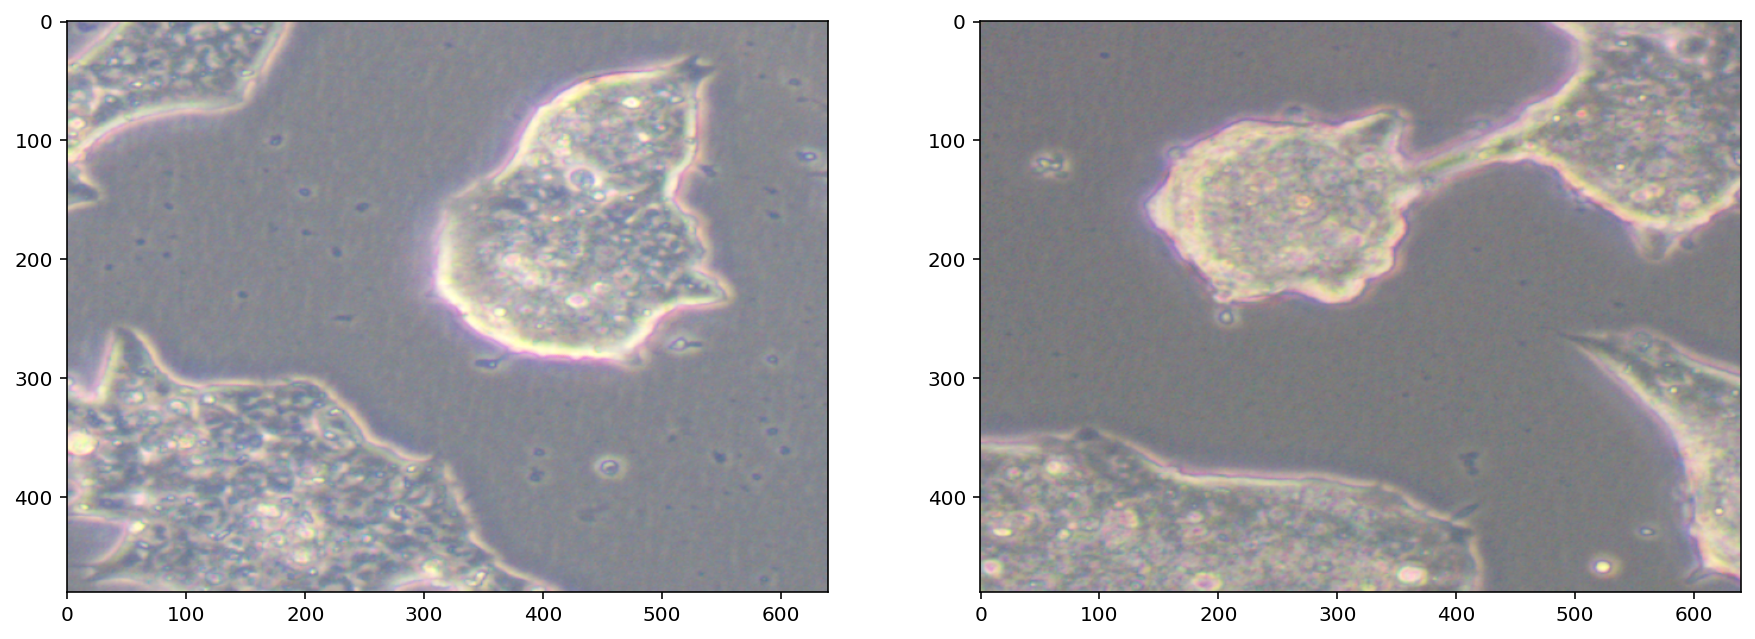

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

rcParams['figure.figsize'] = 15 ,10

img_A = mpimg.imread("miPSC_LIF(+)4SMs(+).tiff")
img_B = mpimg.imread("miPSC_LIF(-)4SMs(-).tiff")

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);

img_A.shape

## Resnet50 Training model

In [ ]:
from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras import regularizers

input = Input(shape=(240, 320, 3))
model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')

x = model.output
x = Dense(1024, name='fully', init='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(512, init='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(2, activation='softmax', name='softmax')(x)
miPSC_ConBase_P1_1H = Model(model.input, x)
miPSC_ConBase_P1_1H.summary()

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras_tqdm import TQDMCallback


train_dir = os.path.join('/home/mjkim/downloads/miPSC/Line2/Con Base/P1_1H/train')
validation_dir = os.path.join('/home/mjkim/downloads/miPSC/Line2/Con Base/P1_1H/validation')
test_dir = os.path.join('/home/mjkim/downloads/miPSC/Line2/Con Base/P1_1H/test')

nb_train_samples = 4000
nb_validation_samples=1600

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=20)
csv_logger = CSVLogger('/home/mjkim/downloads/miPSC/Line2/Con Base/P1_1H/P1_1H.csv')

batch_size = 20
nb_classes = 2
epochs = 100
img_rows, img_cols = 240, 320
img_channels = 3

train_datagen = ImageDataGenerator(
    rescale=1. /255,
    horizontal_flip = True,
    vertical_flip = True)
valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(240, 320),
    batch_size = 40,
    class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(240, 320),
    batch_size = 40,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(240, 320),
    batch_size = 40,
    class_mode='binary', 
    shuffle = False)

In [ ]:
miPSC_ConBase_P1_1H.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = miPSC_ConBase_P1_1H.fit_generator(
    train_generator,
    epochs = 100,
    verbose=0,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    shuffle = True,
    callbacks=[lr_reducer, early_stopper, csv_logger, TQDMCallback()])

## Model savings 

In [ ]:
miPSC_ConBase_P1_1H.save('miPSC_ConBase_P1_1H model.h5')

## The graph of Accuracy and Loss graph 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
plt.style.use("ggplot")
plt.figure()

plt.plot(epochs,
         smooth_curve(acc), 'b', label='Training acc', color='red')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Validation acc')
plt.axhline(y=1, ls='dotted', color='k')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'b', label='Training loss', color='red')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

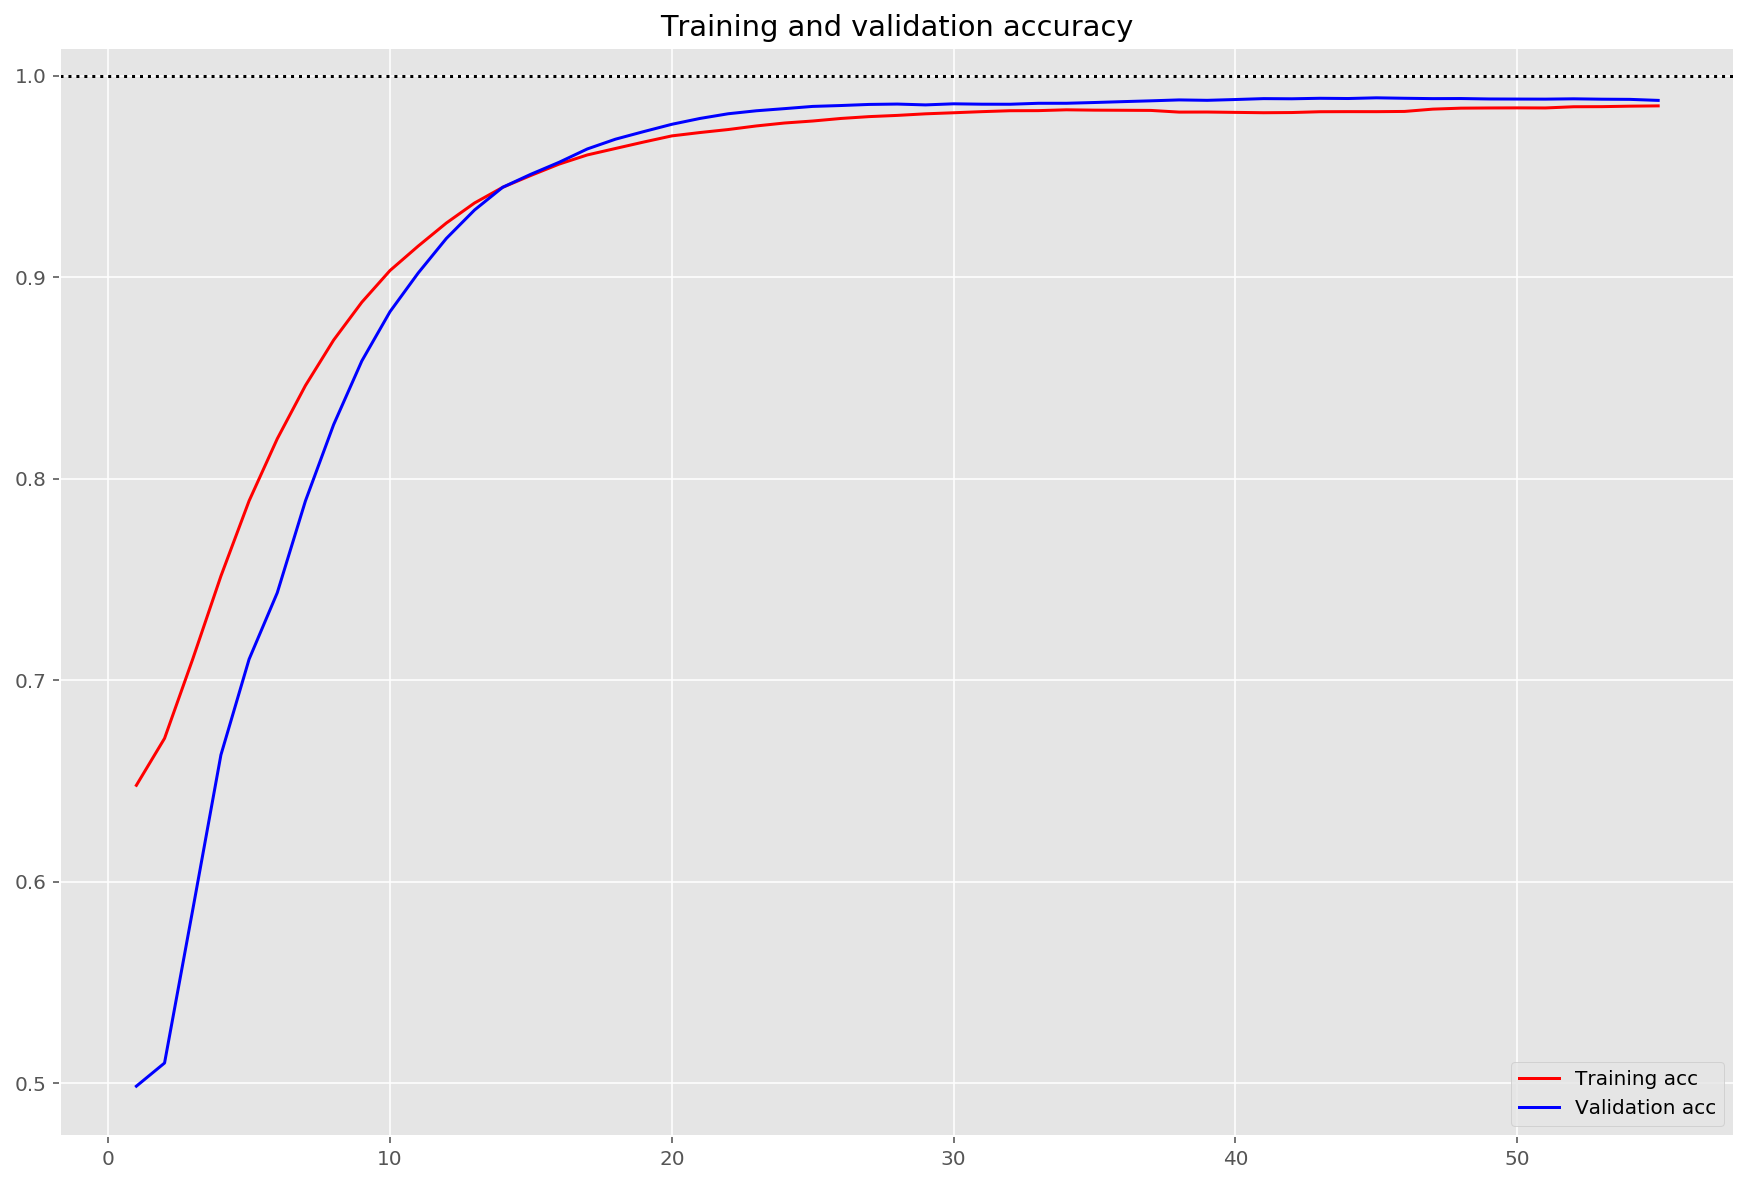

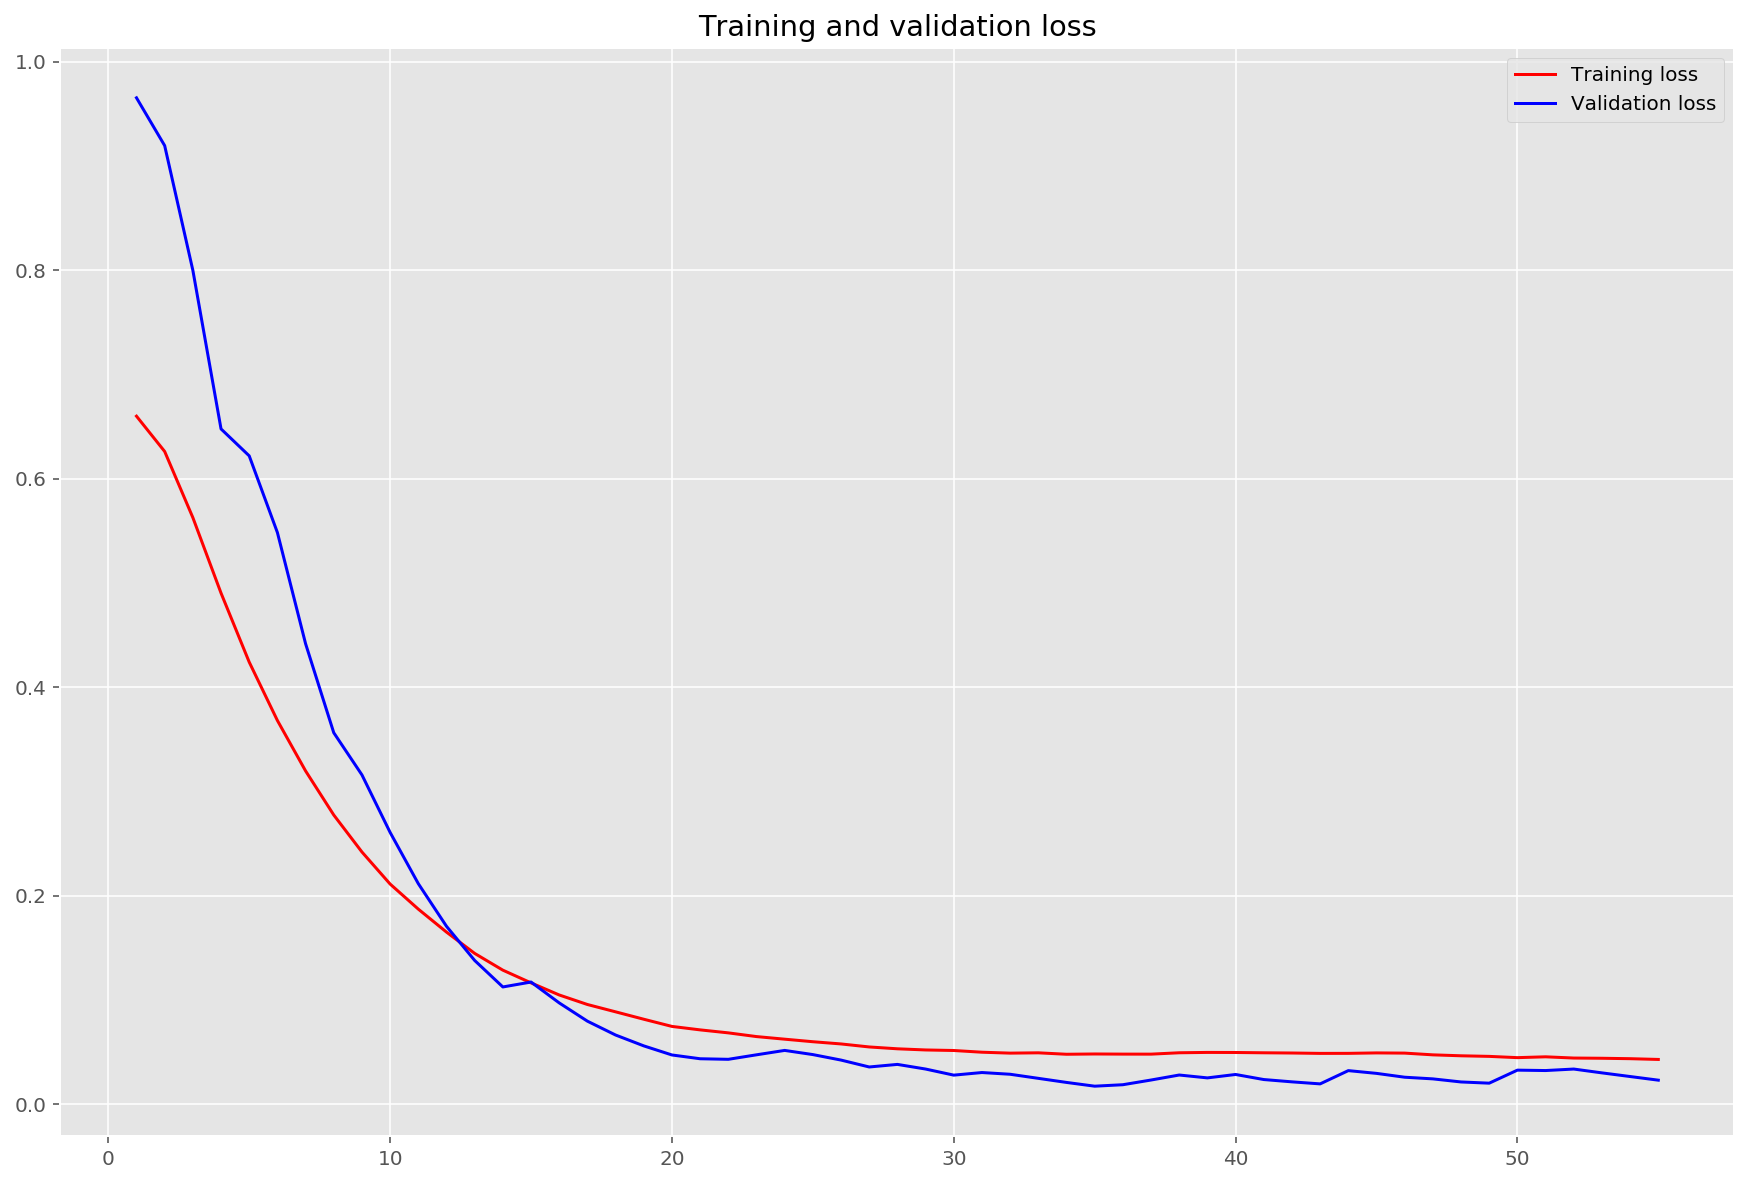

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.style.use("ggplot")
plt.figure()

acc = df['acc']
val_acc = df['val_acc']
loss = df['loss']
val_loss = df['val_loss']

plt.plot(smooth_curve(loss), 'y', label='train loss')
plt.plot(smooth_curve(val_loss), 'r', label='val loss')

plt.plot(smooth_curve(acc), 'b', label='train acc')
plt.plot(smooth_curve(val_acc), 'g', label='val acc')

plt.title('1H')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend()

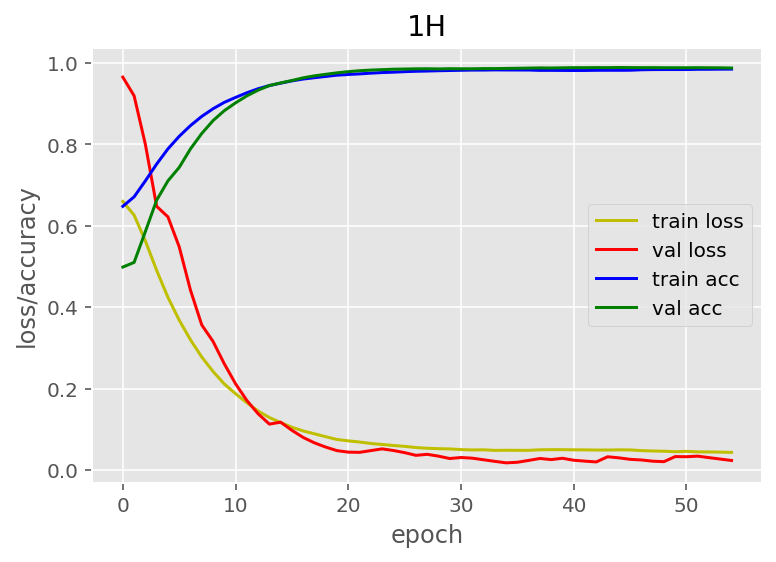

## Model Prediction 

In [ ]:
print("-- Evaluate --")
scores = miPSC_ConBase_P1_1H.evaluate_generator(test_generator, steps=20)
print("%s: %.2f%%" %(miPSC_ConBase_P1_1H.metrics_names[1], scores[1]*100))

In [ ]:
test_generator.reset()
prob = miPSC_ConBase_P1_1H.predict_generator(test_generator)
#print(prob)
y_pred = np.argmax(prob, axis=1)
print(y_pred)
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

target_names = ['miPSC #2_LIF/4Chem_P1_1H', 'miPSC #2_LIF-/4Chems-_P1_1H']

print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas import DataFrame 

df = pd.read_csv('/home/mjkim/downloads/miPSC/Line2/Con Base/P1_1H/P1_1H.csv')
print(df)

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import itertools
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
target_names2 = ['LIF/4CHEM', 'LIF-/4CHEM-']
plt.figure()
plot_confusion_matrix(cm, classes=target_names2, normalize=False,
                      title='Confusion Matrix, 1 hour')
plt.show()